# Reinforcement learning
Reinforcement learning on the pyworld3 model. The goal is to get a reinforcement learning agent to improve upon the standard run and thens tudy what controls were implemented for the improved run. With improving on the standard run we mean that one aspect of it performs better according to some predefined reward function. \
Training data can be obtained by running data_generation.py

In [1]:
import numpy as np
from pyworld3 import World3
from matplotlib import pyplot as plt
import pandas as pd
from tqdm import tqdm

## Data extraction and training of neural net
This assumes that there is some file with rewards J and states stored for randomized runs.

In [2]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

filepath = "data_reward_le.parquet"
df = pd.read_parquet(filepath)
state_variables = df.columns[df.columns != "J"]

In [3]:
class neuralNet(nn.Module):
    def __init__(self, in_dim, out_dim):
        # 2 hidden layers
        super(neuralNet, self).__init__()
        self.input_layer = nn.Linear(in_features=in_dim, out_features=64)
        self.hidden_layer1 = nn.Linear(in_features=64, out_features=64) 
        self.hidden_layer2 = nn.Linear(in_features=64, out_features=32)
        self.outLayer = nn.Linear(in_features=32, out_features=out_dim)

    def forward(self, x):
        # forward pass with relu activation function
        x = torch.relu(self.input_layer(x))
        x = torch.relu(self.hidden_layer1(x))
        x = torch.relu(self.hidden_layer2(x))
        x = self.outLayer(x)
        return x

### Preprocessing
Preprocessing is a 80, 20 training test split. \
Normalizing data by setting mean to zero and variance to one for each variable.

In [4]:
X = df.drop(columns=["J"]).to_numpy()
J = df["J"].to_numpy().reshape(-1,1)

X_train, X_test, J_train, J_test = train_test_split(X, J, test_size=0.2, random_state=42)

# normalizing
X_normalizer = StandardScaler()
X_train = X_normalizer.fit_transform(X_train)
X_test = X_normalizer.transform(X_test)
J_normalizer = StandardScaler()
J_train = J_normalizer.fit_transform(J_train)
J_test = J_normalizer.transform(J_test)

# turning into pytorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
J_train = torch.tensor(J_train, dtype=torch.float32)
J_test = torch.tensor(J_test, dtype=torch.float32)

### Training and creating a function

100%|██████████| 250/250 [00:44<00:00,  5.60it/s]


Error on test set: 0.0024925980251282454


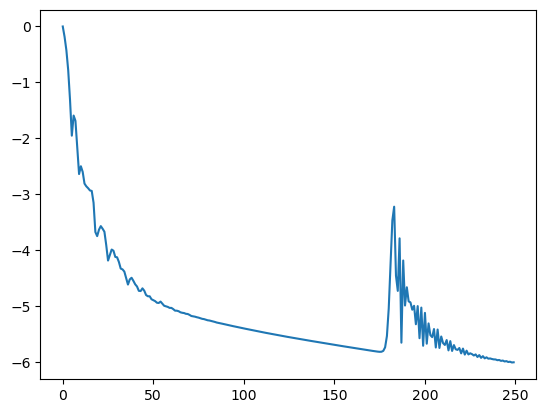

In [5]:
model = neuralNet(X_train.shape[1], 1)
loss_func = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


epochs = 250
losses = np.zeros((epochs,1))
model.train()

for epoch in tqdm(range(epochs)):
    J_pred = model.forward(X_train)
    loss = loss_func(J_pred, J_train)

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    losses[epoch] = loss.item()

model.eval()

with torch.no_grad():
    J_pred = model.forward(X_test)
    loss = loss_func(J_pred, J_test)

    print("Error on test set:", loss.item())

plt.plot(np.log(losses))

In [6]:
def nn_func(model, world, k):
    """ 
    model: neural network model
    world: World3 object
    k: current iteration

    Returns
        J_hat
    """
    model.eval()
    state = np.array([getattr(world, var)[k] for var in state_variables])
    state = X_normalizer.transform(state.reshape(1, -1))
    state = torch.tensor(state, dtype=torch.float32)
    with torch.no_grad():
        J_ = model.forward(state)
    return J_.item()

## Optimization

In [7]:
def loop0(world):
    world.redo_loop = True
    while world.redo_loop:  # unsorted updates at initialization only
        world.redo_loop = False
        world.loop0_population()
        world.loop0_capital()
        world.loop0_agriculture()
        world.loop0_pollution()
        world.loop0_resource()
    
def generate_fioac_control_values():
    return np.linspace(0.01,0.99,100)

def get_fioac_control(world3, k, steps, J_hat):
    """ 
    In:
        world3: pyworld3 simulation
        k: current iteration
        steps: how many steps to look ahead
        J_hat: Approximation of J function
    Returns:
        control: control value
    """
    # _self._loopk_world3_fast(k_ - 1, k_, k_ - 1, k_)  # sorted updates
    n = world3.n
    steps = min(30,n-k)
    control = 0.43
    world3.fioac_control = lambda _: control
    for k_new in range(k,k+steps):
        world3._loopk_world3_fast(k_new-1, k_new, k_new-1, k_new)
    best_J = J_hat(world3, k+steps-1)
    fioac_controls = generate_fioac_control_values()
    for val in fioac_controls:
        world3.fioac_control = lambda _: val
        for k_new in range(k,k+steps):
            world3._loopk_world3_fast(k_new-1, k_new, k_new-1, k_new)
            J_new = J_hat(world3, k_new) # iffy
        if J_new > best_J:
            best_J = J_new
            control = val
    return control

def J_func(reward):
    """ 
    In:
        reward - numpy array: rewards for the simlation
    Out: 
        Array of J function values
    
    Computes the cumulative reward for each step onwards
    """
    iterations = reward.shape[0]
    J = np.zeros((iterations,1))
    J[iterations-1] = reward[iterations-1]
    for k in range(2,iterations+1):
        # J[n] is the reward at step n plus J[n+1]
        J[iterations-k] = reward[iterations-k] + J[iterations-k+1] 
    return J

In [8]:
max_year = 2100
world_control = World3(year_max=max_year)
world_control.set_world3_control()
world_control.init_world3_constants()
world_control.init_world3_variables()
world_control.set_world3_table_functions()
world_control.set_world3_delay_functions()

world_reference = World3(year_max=max_year)
world_reference.set_world3_control()
world_reference.init_world3_constants()
world_reference.init_world3_variables()
world_reference.set_world3_table_functions()
world_reference.set_world3_delay_functions()
world_reference.run_world3(fast=True)

# loop0 first
loop0(world_control)

for k in range(1,world_control.n):
    if k % 10 == 0 and world_control.time[k]:
        J_hat = lambda world, k: nn_func(model, world, k)
        control_val = get_fioac_control(world_control, k, 60, J_hat)
        world_control.fioac_control = lambda _: control_val
        world_control._loopk_world3_fast(k -1, k, k-1, k)
    else:
        world_control._loopk_world3_fast(k -1, k, k-1, k)
        

### Results

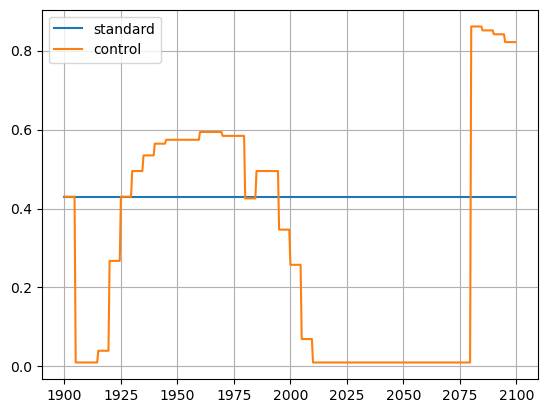

In [15]:
start = 0
end = -1
plt.plot(world_reference.time[start:end], world_reference.fioac[start:end], label="standard")
plt.plot(world_control.time[start:end], world_control.fioac[start:end], label="control")
plt.grid()
plt.legend()

Plot of the rewards for the control run. Nwural network for the control run and standard run starting from each state in the control run but with standard run instead.

In [ ]:
def standard_run_from(world, k):
    initial_state = {}
    for var in state_variables:
        if var == "time":
            continue
        val = getattr(world, var)[k]
        initial_state[var+"i"] = val

    world_temp = World3(year_max=2100, year_min=world.time[k])
    world_temp.set_world3_control()
    world_temp.init_world3_constants(**initial_state)
    world_temp.init_world3_variables()
    world_temp.set_world3_table_functions()
    world_temp.set_world3_delay_functions()
    world_temp.run_world3(fast=True)

    J_ = J_func(world_temp.le) # this can probably be more dynamic
    return J_[0] # only want the first value

In [ ]:
time = world_control.time

J_control = J_func(world_control.le) # This can probably be more dynamic
J_standard = J_func(world_reference.le)
nn_control = np.zeros((world_control.n,1))
nn_standard = np.zeros((world_reference.n,1))
standard_on_control = np.zeros((world_control.n,1))

for k in range(0, world_control.n):
    standard_on_control[k] = standard_run_from(world_control, k)
    nn_control[k] = nn_func(model, world_control, k)
    nn_standard[k] = nn_func(model, world_reference, k)

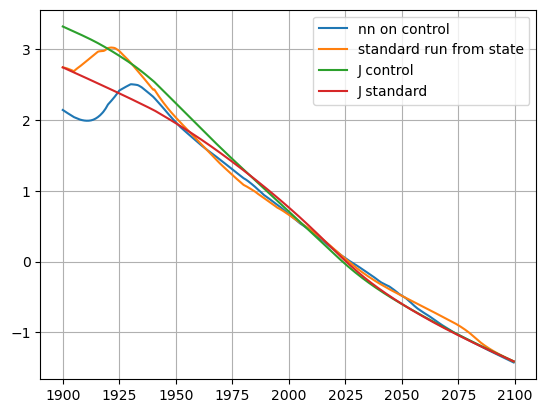

In [28]:
start = 0
end = -1

plt.plot(time[start:end], nn_control[start:end], label="nn on control")
plt.plot(time[start:end], J_normalizer.transform(standard_on_control)[start:end], label="standard run from state")
# plt.plot(time, nn_standard, label="nn on standard")
plt.plot(time[start:end], J_normalizer.transform(J_control)[start:end], label="J control")
plt.plot(time[start:end], J_normalizer.transform(J_standard)[start:end], label="J standard")
plt.legend()
plt.grid()
plt.show()

*Comments* the control does perform better, but it performs rather bad at the end. Might be because he training data there is bad. The control also needs a very long look ahead to do anything useful